# Mount Drive

In [98]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/'My Drive/Transsight/QSR'
%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Transsight/QSR
APC_Model.ipynb                   data/          RFM.ipynb
APC_TimeSeries_Experiments.ipynb  docs/
Churn_prediction.ipynb            QRS_EDA.ipynb


# Libraries

In [103]:
import numpy as np
import pandas as pd
from datetime import timedelta
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Churn Prediction

## Churn data

### Complete data

In [142]:
churn_df = pd.read_csv("data/churn_data.csv")
print("Number of rows : ", len(churn_df))
churn_df.head(2)

Number of rows :  514740


,CustomerID,channelId,Transaction_date,Data_type,Recency,Frequency,Monetary,Churn
0,1,1,2018-05-15,train,47,1,374.32,Yes
1,2,1,2018-05-31,train,31,1,427.99,Yes


### Basic Info

#### Check basic info

##### Duplicates

In [5]:
churn_df[churn_df.duplicated(keep=False)].head(4)

,CustomerID,channelId,Transaction_date,Data_type,Recency,Frequency,Monetary,Churn


##### Null values

In [6]:
count=churn_df.isnull().sum().sort_values(ascending=False)
ratio=count/len(churn_df)
pd.concat([count,ratio],axis=1,keys=['count','ratio'])

,count,ratio
Churn,0,0.0
Monetary,0,0.0
Frequency,0,0.0
Recency,0,0.0
Data_type,0,0.0
Transaction_date,0,0.0
channelId,0,0.0
CustomerID,0,0.0


#### Statistics

In [7]:
churn_df.describe()

,CustomerID,channelId,Recency,Frequency,Monetary
count,514740.000000,514740.000000,514740.000000,514740.000000,514740.000000
mean,260815.377332,1.622326,16.670290,1.622326,738.236315
std,151768.529446,0.484806,11.234266,0.484806,565.644165
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,129678.750000,1.000000,8.000000,1.000000,404.490000
50%,259505.500000,2.000000,16.000000,2.000000,654.320000
75%,389427.250000,2.000000,24.000000,2.000000,955.620000
max,529567.000000,2.000000,61.000000,2.000000,97263.060000


#### Unique values

In [125]:
churn_df.nunique()

CustomerID          514740
channelId                2
Transaction_date        57
Data_type                3
Recency                 57
Frequency                2
Monetary            142362
Churn                    2
dtype: int64

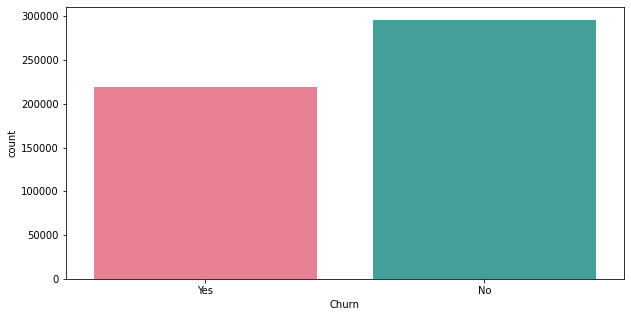

In [9]:
plt.figure(figsize=(10, 5))
sns.countplot(x="Churn", data=churn_df, palette="husl")

### Data Splitting

In [143]:
train_df = churn_df.loc[churn_df.Data_type =='train']
val_test_df = churn_df.loc[(churn_df.Data_type =='val')|(churn_df.Data_type =='test')]
val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=0)
train_df.head(2)

,CustomerID,channelId,Transaction_date,Data_type,Recency,Frequency,Monetary,Churn
0,1,1,2018-05-15,train,47,1,374.32,Yes
1,2,1,2018-05-31,train,31,1,427.99,Yes


In [144]:
val_df.head(2)

,CustomerID,channelId,Transaction_date,Data_type,Recency,Frequency,Monetary,Churn
458891,468664,1,2018-06-27,test,4,1,722.01,No
260971,263141,2,2018-06-16,val,15,2,458.18,Yes


In [145]:
test_df.head(2)

,CustomerID,channelId,Transaction_date,Data_type,Recency,Frequency,Monetary,Churn
365795,368822,2,2018-06-22,test,9,2,919.41,No
308377,310936,2,2018-06-19,val,12,2,385.16,No


### Data preprocessing pipeline

In [146]:
def data_preprocessing(df, label=None):
    return((df.drop([label, 'Transaction_date', 'Data_type'], axis=1), df[label]) if label else df.drop([label], axis=1))

In [147]:
x_train, y_train = data_preprocessing(train_df, 'Churn')
x_train.head(2)

,CustomerID,channelId,Recency,Frequency,Monetary
0,1,1,47,1,374.32
1,2,1,31,1,427.99


### Training and Evaluation

In [150]:
x_train, y_train = data_preprocessing(train_df, 'Churn')
x_val, y_val = data_preprocessing(val_df, 'Churn')
x_test, y_test = data_preprocessing(test_df, 'Churn')

rf = RandomForestClassifier(random_state=0)
rf.fit(x_train, y_train);

print('********************Evaluation on Validation data********************')
y_pred = rf.predict(x_val)
print(classification_report(y_val, y_pred))

print('\n********************Evaluation on Test data********************')
y_pred = rf.predict(x_test)
print(classification_report(y_test, y_pred))

********************Evaluation on Validation data********************
              precision    recall  f1-score   support

          No       1.00      0.74      0.85     95419
         Yes       0.62      1.00      0.77     40935

    accuracy                           0.82    136354
   macro avg       0.81      0.87      0.81    136354
weighted avg       0.89      0.82      0.83    136354


********************Evaluation on Test data********************
              precision    recall  f1-score   support

          No       1.00      0.74      0.85     95528
         Yes       0.62      1.00      0.77     40826

    accuracy                           0.82    136354
   macro avg       0.81      0.87      0.81    136354
weighted avg       0.89      0.82      0.83    136354



### Channel Vulnerability based on churn

#### Prepare data

In [86]:
trans_df = pd.read_csv('data/TransactionData - masked.csv')
trans_df.head(2)

,CustomerID,GuestcheckId,city,Transaction Date,MobileNo,Last Update,channelId,CheckNo,TotalAmount
0,386191,727585634,NaN,23 Jun 18,9821XXXX691,23 Jun 18,Dine In,2506,200.34
1,111063,721708340,MOHALI,8 Jun 18,9821XXXX718,8 Jun 18,Mobile App,7499,234.30


In [87]:
previous_data_size = len(trans_df)
trans_df = trans_df.loc[trans_df.TotalAmount > 0]

trans_df.drop('city', axis=1, inplace=True)
trans_df.dropna(inplace=True)
current_data_size = len(trans_df)

print('Number of dropped rows : ', previous_data_size - current_data_size)
print('Ratio of dropped rows : ', (previous_data_size - current_data_size)/previous_data_size)
print("Final data size : ", len(trans_df))

Number of dropped rows :  11293
Ratio of dropped rows :  0.013342879996786272
Final data size :  835076


In [88]:
trans_df['Churn'] = trans_df['CustomerID'].map(churn_df.set_index('CustomerID')['Churn'])

#### Channel vulnerability on based on churn ratio

In [92]:
churn_vul_df = trans_df.assign(Churn_count=trans_df['Churn']).groupby(['channelId', 'Churn']).agg({'Churn_count': 'count'}).reset_index()
churn_vul_df['Churn_ratio'] = churn_vul_df.Churn_count / trans_df.CustomerID.nunique()
churn_vul_df

,channelId,Churn,Churn_count,Churn_ratio
0,Call center,No,65969,0.128160
1,Call center,Yes,27986,0.054369
2,Dine In,No,333853,0.648586
3,Dine In,Yes,250580,0.486809
4,Facebook,No,4,0.000008
5,Facebook,Yes,6,0.000012
6,Food Panda,No,6856,0.013319
7,Food Panda,Yes,4084,0.007934
8,Mobile App,No,14355,0.027888
9,Mobile App,Yes,6602,0.012826


### Channel vulnerability plot

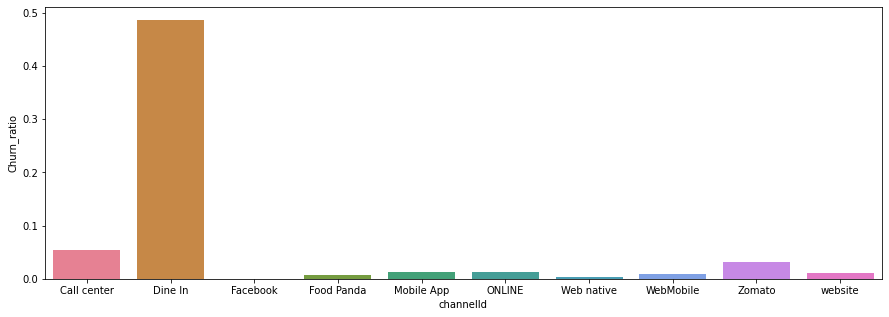

In [97]:
plt.figure(figsize=(15, 5))
sns.barplot(x="channelId", y='Churn_ratio', data=churn_vul_df.loc[churn_vul_df.Churn == 'Yes'], palette="husl")

### Churn prediction per channel

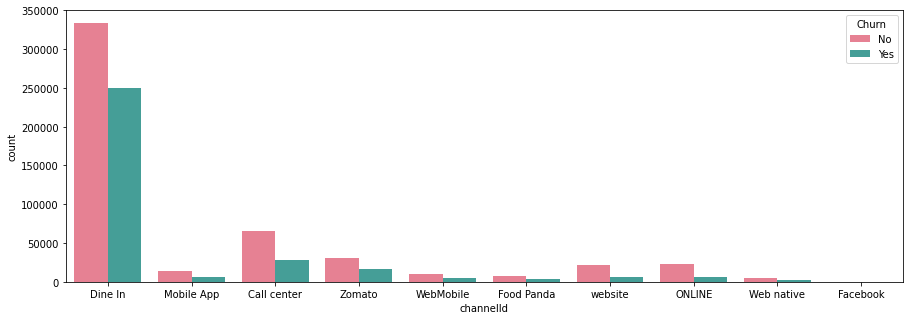

In [89]:
plt.figure(figsize=(15, 5))
sns.countplot(x="channelId", data=trans_df, palette="husl", hue='Churn')